<div align="center">

# MEGR7172/8172

### Computational Methods (Fall 2025)
### Duke 227, Tu/Th 08:30 - 09:45 pm

</div>


# 17 2D and higher cases

Here we extend the 1D heat-equation discussion to two and higher spatial dimensions. We illustrate formulation, discretization, and stability in 2D and implement four numerical approaches (explicit FTCS, implicit/backward Euler, Crank–Nicolson, and ADI) on a unit square ($L_x = L_y = 1.0$) with a uniform grid ($N_x × N_y$). Results compare accuracy, stability, computational cost, and error maps against the analytical sinusoidal solution, and discuss practical choices.



## 17.1 2D Heat Equation

The 2D heat equation extends the 1D case to include spatial derivatives in both x and y directions:

$$\frac{\partial u}{\partial t} = \alpha \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right)$$

or more compactly: $$\frac{\partial u}{\partial t} = \alpha \nabla^2 u$$

**Discretization on a 2D grid:**
- Spatial grid: $(x_i, y_j) = (i\Delta x, j\Delta y)$ where $i = 0, 1, ..., N_x$ and $j = 0, 1, ..., N_y$
- Time discretization: $t^n = n\Delta t$
- Solution: $u_{i,j}^n \approx u(i\Delta x, j\Delta y, n\Delta t)$

**Finite difference approximations:**
$$\frac{\partial^2 u}{\partial x^2} \bigg|_{i,j} \approx \frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{(\Delta x)^2}$$

$$\frac{\partial^2 u}{\partial y^2} \bigg|_{i,j} \approx \frac{u_{i,j+1} - 2u_{i,j} + u_{i,j-1}}{(\Delta y)^2}$$

## 17.2 Explicit Scheme for 2D Heat Equation

Using forward difference in time and central differences in space:

$$\frac{u_{i,j}^{n+1} - u_{i,j}^n}{\Delta t} = \alpha \left[\frac{u_{i+1,j}^n - 2u_{i,j}^n + u_{i-1,j}^n}{(\Delta x)^2} + \frac{u_{i,j+1}^n - 2u_{i,j}^n + u_{i,j-1}^n}{(\Delta y)^2}\right]$$

**Rearranging for the explicit update:**

With parameters $r_x = \frac{\alpha \Delta t}{(\Delta x)^2}$ and $r_y = \frac{\alpha \Delta t}{(\Delta y)^2}$:

$$u_{i,j}^{n+1} = u_{i,j}^n + r_x(u_{i+1,j}^n - 2u_{i,j}^n + u_{i-1,j}^n) + r_y(u_{i,j+1}^n - 2u_{i,j}^n + u_{i,j-1}^n)$$

$$u_{i,j}^{n+1} = (1 - 2r_x - 2r_y)u_{i,j}^n + r_x(u_{i+1,j}^n + u_{i-1,j}^n) + r_y(u_{i,j+1}^n + u_{i,j-1}^n)$$

**Stability condition:**
For stability, we need $1 - 2r_x - 2r_y \geq 0$, which gives:
$$r_x + r_y \leq \frac{1}{2}$$

For square grids ($\Delta x = \Delta y$), this becomes $r \leq \frac{1}{4}$, making the 2D explicit scheme **more restrictive** than the 1D case!



## 17.3 Implicit Scheme for 2D Heat Equation

Using backward difference in time and central differences in space at the new time level:

$$\frac{u_{i,j}^{n+1} - u_{i,j}^n}{\Delta t} = \alpha \left[\frac{u_{i+1,j}^{n+1} - 2u_{i,j}^{n+1} + u_{i-1,j}^{n+1}}{(\Delta x)^2} + \frac{u_{i,j+1}^{n+1} - 2u_{i,j}^{n+1} + u_{i,j-1}^{n+1}}{(\Delta y)^2}\right]$$

**Rearranging:**
$$u_{i,j}^{n+1} - r_x(u_{i+1,j}^{n+1} - 2u_{i,j}^{n+1} + u_{i-1,j}^{n+1}) - r_y(u_{i,j+1}^{n+1} - 2u_{i,j}^{n+1} + u_{i,j-1}^{n+1}) = u_{i,j}^n$$

$$-r_x u_{i-1,j}^{n+1} - r_y u_{i,j-1}^{n+1} + (1 + 2r_x + 2r_y)u_{i,j}^{n+1} - r_x u_{i+1,j}^{n+1} - r_y u_{i,j+1}^{n+1} = u_{i,j}^n$$

**Matrix system:**
This creates a **sparse linear system** $\mathbf{A}\mathbf{u}^{n+1} = \mathbf{u}^n$ where:
- The matrix $\mathbf{A}$ has a **five-diagonal structure** (pentadiagonal)
- Each interior point couples to its 4 nearest neighbors
- **Unconditionally stable** for any time step size
- More expensive to solve than 1D tridiagonal systems


2D Heat Equation Comparison: Explicit vs Implicit
Explicit 2D: rx = 0.1000, ry = 0.1000, rx+ry = 0.2000
Stability condition: rx + ry = 0.2000 <= 0.5: True
Implicit 2D: rx = 1.0000, ry = 1.0000, rx+ry = 2.0000

Time step comparison:
Explicit dt = 1.11e-02
Implicit dt = 1.11e-01
Ratio: 10.0


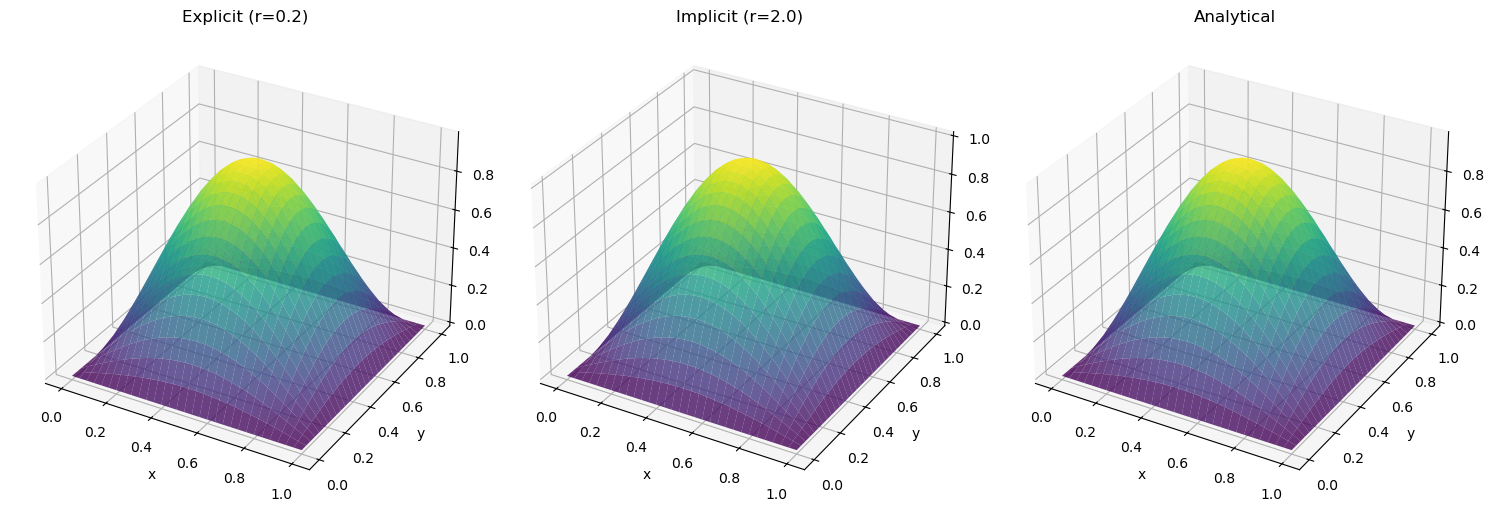


Error analysis at t = 0.1:
Explicit error: 5.30e-05
Implicit error: 2.93e-01


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D

def solve_heat_2d_explicit(Lx, Ly, alpha, t_max, Nx, Ny, r):
    """
    Solve 2D heat equation using explicit finite difference scheme
    """
    # Grid setup
    dx = Lx / Nx
    dy = Ly / Ny
    dt = r * min(dx**2, dy**2) / (2 * alpha)  # Stability-limited time step
    Nt = int(t_max / dt)
    
    x = np.linspace(0, Lx, Nx + 1)
    y = np.linspace(0, Ly, Ny + 1)
    X, Y = np.meshgrid(x, y)
    
    # Initial condition: u(x,y,0) = sin(πx/Lx) * sin(πy/Ly)
    u = np.sin(np.pi * X / Lx) * np.sin(np.pi * Y / Ly)
    
    # Parameters
    rx = alpha * dt / dx**2
    ry = alpha * dt / dy**2
    
    print(f"Explicit 2D: rx = {rx:.4f}, ry = {ry:.4f}, rx+ry = {rx+ry:.4f}")
    print(f"Stability condition: rx + ry = {rx+ry:.4f} <= 0.5: {rx+ry <= 0.5}")
    
    # Time stepping
    for n in range(Nt):
        u_new = u.copy()
        
        # Update interior points
        u_new[1:-1, 1:-1] = (u[1:-1, 1:-1] + 
                             rx * (u[2:, 1:-1] - 2*u[1:-1, 1:-1] + u[:-2, 1:-1]) +
                             ry * (u[1:-1, 2:] - 2*u[1:-1, 1:-1] + u[1:-1, :-2]))
        
        # Boundary conditions (homogeneous Dirichlet)
        u_new[0, :] = 0
        u_new[-1, :] = 0
        u_new[:, 0] = 0
        u_new[:, -1] = 0
        
        u = u_new
    
    return X, Y, u, dt

def solve_heat_2d_implicit(Lx, Ly, alpha, t_max, Nx, Ny, r):
    """
    Solve 2D heat equation using implicit finite difference scheme
    """
    # Grid setup
    dx = Lx / Nx
    dy = Ly / Ny
    dt = r * min(dx**2, dy**2) / (2 * alpha)  # Can be much larger for implicit
    Nt = int(t_max / dt)
    
    x = np.linspace(0, Lx, Nx + 1)
    y = np.linspace(0, Ly, Ny + 1)
    X, Y = np.meshgrid(x, y)
    
    # Initial condition
    u = np.sin(np.pi * X / Lx) * np.sin(np.pi * Y / Ly)
    
    # Parameters
    rx = alpha * dt / dx**2
    ry = alpha * dt / dy**2
    
    print(f"Implicit 2D: rx = {rx:.4f}, ry = {ry:.4f}, rx+ry = {rx+ry:.4f}")
    
    # Build the coefficient matrix for implicit scheme
    N_interior = (Nx-1) * (Ny-1)  # Number of interior points
    
    # Create row and column indices for sparse matrix
    rows, cols, data = [], [], []
    
    for j in range(Ny-1):  # y-direction
        for i in range(Nx-1):  # x-direction
            idx = j * (Nx-1) + i  # Linear index
            
            # Main diagonal
            rows.append(idx)
            cols.append(idx)
            data.append(1 + 2*rx + 2*ry)
            
            # x-direction neighbors
            if i > 0:  # left neighbor
                rows.append(idx)
                cols.append(idx - 1)
                data.append(-rx)
            if i < Nx-2:  # right neighbor
                rows.append(idx)
                cols.append(idx + 1)
                data.append(-rx)
            
            # y-direction neighbors
            if j > 0:  # bottom neighbor
                rows.append(idx)
                cols.append(idx - (Nx-1))
                data.append(-ry)
            if j < Ny-2:  # top neighbor
                rows.append(idx)
                cols.append(idx + (Nx-1))
                data.append(-ry)
    
    A = csr_matrix((data, (rows, cols)), shape=(N_interior, N_interior))
    
    # Time stepping
    for n in range(Nt):
        # Extract interior points as a vector
        u_interior = u[1:-1, 1:-1].flatten()
        
        # Solve linear system
        u_new_interior = spsolve(A, u_interior)
        
        # Reshape back to 2D and update
        u[1:-1, 1:-1] = u_new_interior.reshape((Ny-1, Nx-1))
        
        # Boundary conditions remain zero (already set)
    
    return X, Y, u, dt

# Compare explicit vs implicit for 2D heat equation
print("2D Heat Equation Comparison: Explicit vs Implicit")

# Parameters
Lx = Ly = 1.0
alpha = 0.01
t_max = 0.1
Nx = Ny = 30

# Explicit scheme (stability-limited)
r_explicit = 0.2  # rx + ry should be ≤ 0.5
X_exp, Y_exp, u_exp, dt_exp = solve_heat_2d_explicit(Lx, Ly, alpha, t_max, Nx, Ny, r_explicit)

# Implicit scheme (can use larger time steps)
r_implicit = 2.0  # Much larger time step
X_imp, Y_imp, u_imp, dt_imp = solve_heat_2d_implicit(Lx, Ly, alpha, t_max, Nx, Ny, r_implicit)

print(f"\nTime step comparison:")
print(f"Explicit dt = {dt_exp:.2e}")
print(f"Implicit dt = {dt_imp:.2e}")
print(f"Ratio: {dt_imp/dt_exp:.1f}")

# Analytical solution for comparison
def analytical_2d(X, Y, t, alpha, Lx, Ly):
    return np.exp(-np.pi**2 * alpha * t * (1/Lx**2 + 1/Ly**2)) * np.sin(np.pi * X / Lx) * np.sin(np.pi * Y / Ly)

u_analytical = analytical_2d(X_exp, Y_exp, t_max, alpha, Lx, Ly)

# Plot results
fig = plt.figure(figsize=(15, 5))

# Explicit solution
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X_exp, Y_exp, u_exp, cmap='viridis', alpha=0.8)
ax1.set_title(f'Explicit (r={r_explicit})')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('u')

# Implicit solution
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X_imp, Y_imp, u_imp, cmap='viridis', alpha=0.8)
ax2.set_title(f'Implicit (r={r_implicit})')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('u')

# Analytical solution
ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(X_exp, Y_exp, u_analytical, cmap='viridis', alpha=0.8)
ax3.set_title('Analytical')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('u')

plt.tight_layout()
plt.show()

# Error analysis
error_exp = np.linalg.norm(u_exp - u_analytical)
error_imp = np.linalg.norm(u_imp - u_analytical)

print(f"\nError analysis at t = {t_max}:")
print(f"Explicit error: {error_exp:.2e}")
print(f"Implicit error: {error_imp:.2e}")

## 17.4 Crank-Nicolson Scheme for 2D Heat Equation

The Crank-Nicolson scheme averages the spatial derivatives at two consecutive time levels:

$$\frac{u_{i,j}^{n+1} - u_{i,j}^n}{\Delta t} = \frac{\alpha}{2}\left[\nabla^2 u_{i,j}^{n+1} + \nabla^2 u_{i,j}^n\right]$$

where 
$$
\nabla^2 u_{i,j} = \frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{(\Delta x)^2} + \frac{u_{i,j+1} - 2u_{i,j} + u_{i,j-1}}{(\Delta y)^2}
$$

**Advantages of 2D Crank-Nicolson:**
- **Second-order accurate** in time: $O((\Delta t)^2)$
- **Unconditionally stable** (like implicit scheme)
- **Less dissipative** than backward Euler
- **Better preservation** of solution features

**Matrix structure:**
Similar to implicit scheme but with modified coefficients to account for the averaging of explicit and implicit parts.

2D Heat Equation: Complete Comparison
Explicit 2D: rx = 0.0750, ry = 0.0750, rx+ry = 0.1500
Stability condition: rx + ry = 0.1500 <= 0.5: True
Implicit 2D: rx = 0.5000, ry = 0.5000, rx+ry = 1.0000
Crank-Nicolson 2D: rx = 0.4000, ry = 0.4000, rx+ry = 0.8000

Time step comparison:
Explicit:       dt = 4.69e-03
Implicit:       dt = 3.13e-02
Crank-Nicolson: dt = 2.50e-02

Error analysis:
Explicit:       1.22e-02
Implicit:       7.39e-02
Crank-Nicolson: 9.80e-02


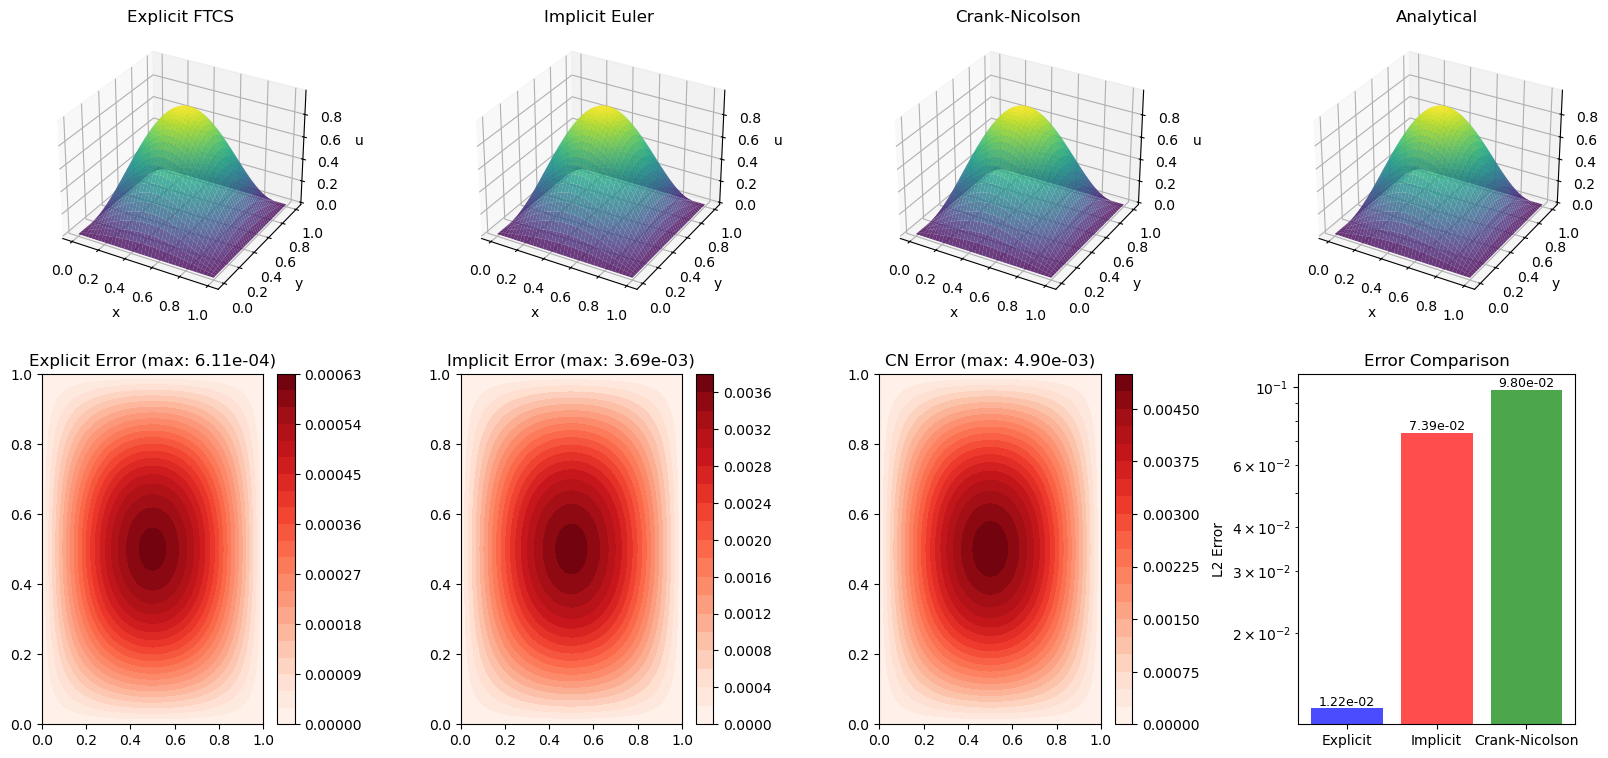

In [4]:
def solve_heat_2d_crank_nicolson(Lx, Ly, alpha, t_max, Nx, Ny, r):
    """
    Solve 2D heat equation using Crank-Nicolson scheme
    """
    # Grid setup
    dx = Lx / Nx
    dy = Ly / Ny
    dt = r * min(dx**2, dy**2) / (2 * alpha)
    Nt = int(t_max / dt)
    
    x = np.linspace(0, Lx, Nx + 1)
    y = np.linspace(0, Ly, Ny + 1)
    X, Y = np.meshgrid(x, y)
    
    # Initial condition
    u = np.sin(np.pi * X / Lx) * np.sin(np.pi * Y / Ly)
    
    # Parameters
    rx = alpha * dt / dx**2
    ry = alpha * dt / dy**2
    
    print(f"Crank-Nicolson 2D: rx = {rx:.4f}, ry = {ry:.4f}, rx+ry = {rx+ry:.4f}")
    
    N_interior = (Nx-1) * (Ny-1)
    
    # Build matrices for Crank-Nicolson: A_lhs * u^{n+1} = A_rhs * u^n
    rows_lhs, cols_lhs, data_lhs = [], [], []
    rows_rhs, cols_rhs, data_rhs = [], [], []
    
    for j in range(Ny-1):
        for i in range(Nx-1):
            idx = j * (Nx-1) + i
            
            # Left-hand side matrix (implicit part)
            # Main diagonal: (1 + rx + ry)
            rows_lhs.append(idx)
            cols_lhs.append(idx)
            data_lhs.append(1 + rx + ry)
            
            # Right-hand side matrix (explicit part)  
            # Main diagonal: (1 - rx - ry)
            rows_rhs.append(idx)
            cols_rhs.append(idx)
            data_rhs.append(1 - rx - ry)
            
            # x-direction neighbors
            if i > 0:  # left
                rows_lhs.append(idx)
                cols_lhs.append(idx - 1)
                data_lhs.append(-rx/2)
                
                rows_rhs.append(idx)
                cols_rhs.append(idx - 1)
                data_rhs.append(rx/2)
                
            if i < Nx-2:  # right
                rows_lhs.append(idx)
                cols_lhs.append(idx + 1)
                data_lhs.append(-rx/2)
                
                rows_rhs.append(idx)
                cols_rhs.append(idx + 1)
                data_rhs.append(rx/2)
            
            # y-direction neighbors
            if j > 0:  # bottom
                rows_lhs.append(idx)
                cols_lhs.append(idx - (Nx-1))
                data_lhs.append(-ry/2)
                
                rows_rhs.append(idx)
                cols_rhs.append(idx - (Nx-1))
                data_rhs.append(ry/2)
                
            if j < Ny-2:  # top
                rows_lhs.append(idx)
                cols_lhs.append(idx + (Nx-1))
                data_lhs.append(-ry/2)
                
                rows_rhs.append(idx)
                cols_rhs.append(idx + (Nx-1))
                data_rhs.append(ry/2)
    
    A_lhs = csr_matrix((data_lhs, (rows_lhs, cols_lhs)), shape=(N_interior, N_interior))
    A_rhs = csr_matrix((data_rhs, (rows_rhs, cols_rhs)), shape=(N_interior, N_interior))
    
    # Time stepping
    for n in range(Nt):
        u_interior = u[1:-1, 1:-1].flatten()
        rhs = A_rhs.dot(u_interior)
        u_new_interior = spsolve(A_lhs, rhs)
        u[1:-1, 1:-1] = u_new_interior.reshape((Ny-1, Nx-1))
    
    return X, Y, u, dt

# Compare all three methods for 2D heat equation
print("2D Heat Equation: Complete Comparison")
print("="*50)

# Parameters
Lx = Ly = 1.0
alpha = 0.01
t_max = 0.05
Nx = Ny = 40

# Test different r values
r_exp = 0.15     # Explicit (must satisfy stability)
r_imp = 1.0      # Implicit (unconditionally stable)
r_cn = 0.8       # Crank-Nicolson (unconditionally stable)

# Solve with all methods
X_exp, Y_exp, u_exp, dt_exp = solve_heat_2d_explicit(Lx, Ly, alpha, t_max, Nx, Ny, r_exp)
X_imp, Y_imp, u_imp, dt_imp = solve_heat_2d_implicit(Lx, Ly, alpha, t_max, Nx, Ny, r_imp)
X_cn, Y_cn, u_cn, dt_cn = solve_heat_2d_crank_nicolson(Lx, Ly, alpha, t_max, Nx, Ny, r_cn)

# Analytical solution
u_analytical = analytical_2d(X_exp, Y_exp, t_max, alpha, Lx, Ly)

print(f"\nTime step comparison:")
print(f"Explicit:       dt = {dt_exp:.2e}")
print(f"Implicit:       dt = {dt_imp:.2e}")
print(f"Crank-Nicolson: dt = {dt_cn:.2e}")

# Error analysis
error_exp = np.linalg.norm(u_exp - u_analytical)
error_imp = np.linalg.norm(u_imp - u_analytical) 
error_cn = np.linalg.norm(u_cn - u_analytical)

print(f"\nError analysis:")
print(f"Explicit:       {error_exp:.2e}")
print(f"Implicit:       {error_imp:.2e}")
print(f"Crank-Nicolson: {error_cn:.2e}")

# Plot comparison
fig = plt.figure(figsize=(16, 8))

# Top row: Numerical solutions
ax1 = fig.add_subplot(241, projection='3d')
ax1.plot_surface(X_exp, Y_exp, u_exp, cmap='viridis', alpha=0.8)
ax1.set_title('Explicit FTCS')
ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.set_zlabel('u')

ax2 = fig.add_subplot(242, projection='3d')
ax2.plot_surface(X_imp, Y_imp, u_imp, cmap='viridis', alpha=0.8)
ax2.set_title('Implicit Euler')
ax2.set_xlabel('x'); ax2.set_ylabel('y'); ax2.set_zlabel('u')

ax3 = fig.add_subplot(243, projection='3d')
ax3.plot_surface(X_cn, Y_cn, u_cn, cmap='viridis', alpha=0.8)
ax3.set_title('Crank-Nicolson')
ax3.set_xlabel('x'); ax3.set_ylabel('y'); ax3.set_zlabel('u')

ax4 = fig.add_subplot(244, projection='3d')
ax4.plot_surface(X_exp, Y_exp, u_analytical, cmap='viridis', alpha=0.8)
ax4.set_title('Analytical')
ax4.set_xlabel('x'); ax4.set_ylabel('y'); ax4.set_zlabel('u')

# Bottom row: Error plots
ax5 = fig.add_subplot(245)
error_map_exp = np.abs(u_exp - u_analytical)
im1 = ax5.contourf(X_exp, Y_exp, error_map_exp, levels=20, cmap='Reds')
ax5.set_title(f'Explicit Error (max: {np.max(error_map_exp):.2e})')
plt.colorbar(im1, ax=ax5)

ax6 = fig.add_subplot(246)
error_map_imp = np.abs(u_imp - u_analytical)
im2 = ax6.contourf(X_imp, Y_imp, error_map_imp, levels=20, cmap='Reds')
ax6.set_title(f'Implicit Error (max: {np.max(error_map_imp):.2e})')
plt.colorbar(im2, ax=ax6)

ax7 = fig.add_subplot(247)
error_map_cn = np.abs(u_cn - u_analytical)
im3 = ax7.contourf(X_cn, Y_cn, error_map_cn, levels=20, cmap='Reds')
ax7.set_title(f'CN Error (max: {np.max(error_map_cn):.2e})')
plt.colorbar(im3, ax=ax7)

# Convergence comparison
ax8 = fig.add_subplot(248)
methods = ['Explicit', 'Implicit', 'Crank-Nicolson']
errors = [error_exp, error_imp, error_cn]
colors = ['blue', 'red', 'green']
bars = ax8.bar(methods, errors, color=colors, alpha=0.7)
ax8.set_ylabel('L2 Error')
ax8.set_title('Error Comparison')
ax8.set_yscale('log')

# Add error values on bars
for bar, error in zip(bars, errors):
    height = bar.get_height()
    ax8.text(bar.get_x() + bar.get_width()/2., height,
             f'{error:.2e}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 17.5 Computational Considerations for 2D and Higher Dimensions

### Matrix Structure and Storage
- **1D**: Tridiagonal matrices (3 diagonals)
- **2D**: Pentadiagonal matrices (5 diagonals) 
- **3D**: Heptadiagonal matrices (7 diagonals)

**Storage requirements grow rapidly:**
- **1D**: $O(N)$ storage for matrix
- **2D**: $O(N^2)$ storage for matrix (where $N^2$ is total grid points)
- **3D**: $O(N^3)$ storage for matrix

### Solving Linear Systems
**Direct methods (LU decomposition):**
- **1D**: $O(N)$ operations (tridiagonal solver)
- **2D**: $O(N^3)$ operations (general sparse solver)
- **3D**: $O(N^{4.5})$ operations (becomes prohibitive)

**Iterative methods** become essential for 3D and higher:
- Conjugate Gradient (CG)
- GMRES
- Multigrid methods

### Alternative Approaches for Higher Dimensions

**1. Operator Splitting / ADI (Alternating Direction Implicit):**
- Split 2D/3D problem into sequence of 1D problems
- Each 1D solve uses efficient tridiagonal solver
- Maintains second-order accuracy

**2. Fractional Step Methods:**
- Solve in x-direction first, then y-direction
- Each step is implicit and unconditionally stable
- More efficient than full implicit scheme

**3. Spectral Methods:**
- Use Fourier or Chebyshev expansions
- Excellent for problems on rectangular domains
- Very high accuracy for smooth solutions

Comparing ADI Method with Standard Approaches
Solving with different methods...
Implicit 2D: rx = 0.5000, ry = 0.5000, rx+ry = 1.0000
Crank-Nicolson 2D: rx = 0.5000, ry = 0.5000, rx+ry = 1.0000
ADI 2D: rx = 0.2500, ry = 0.2500

Time steps:
Implicit:       dt = 1.39e-02
Crank-Nicolson: dt = 1.39e-02
ADI:            dt = 1.39e-02

L2 Errors:
Implicit:       4.93e-02
Crank-Nicolson: 4.90e-02
ADI:            4.90e-02


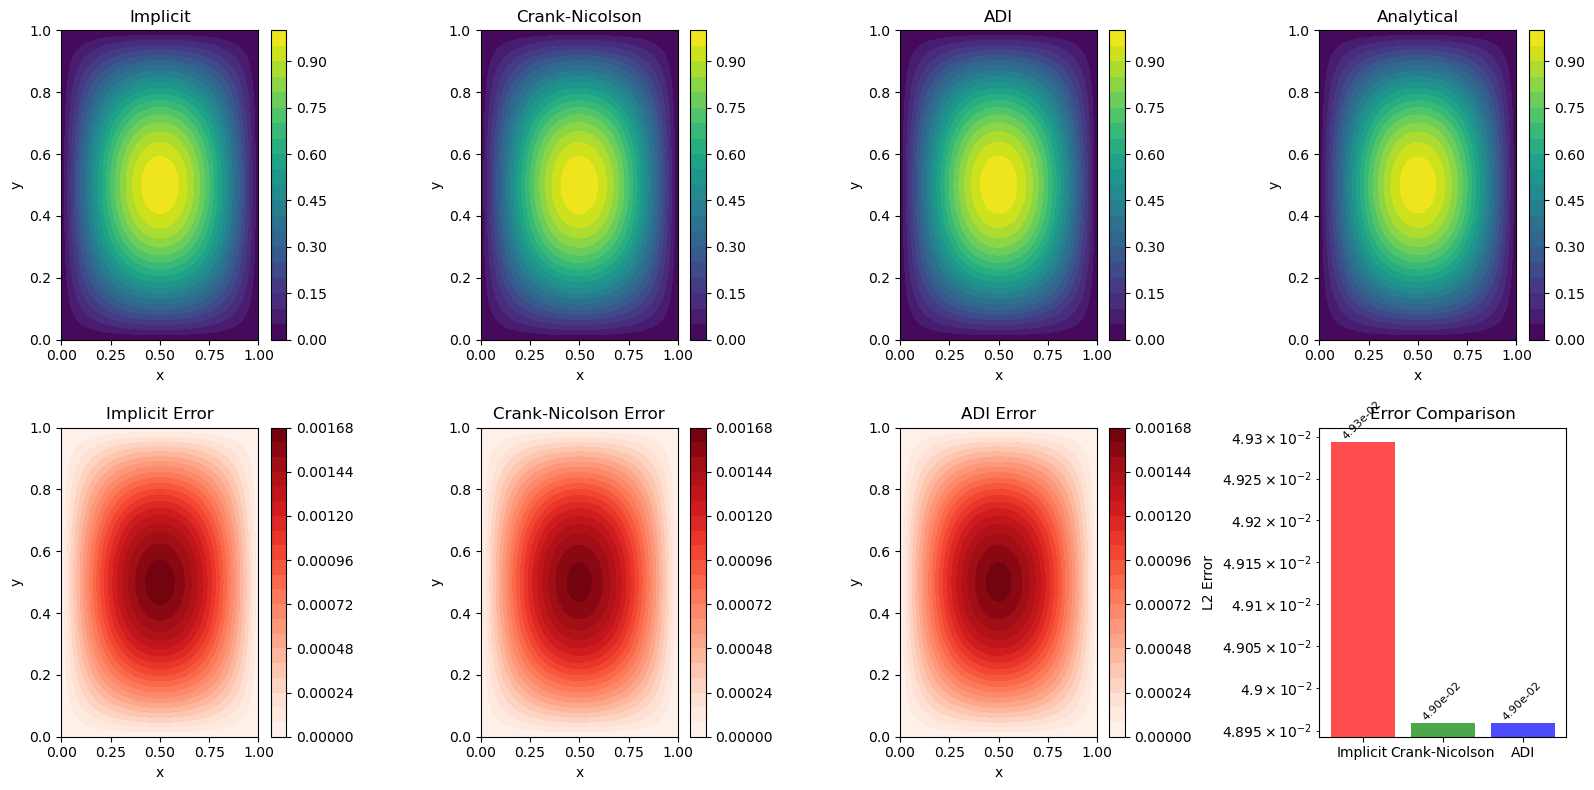

In [5]:
def solve_heat_2d_adi(Lx, Ly, alpha, t_max, Nx, Ny, r):
    """
    Solve 2D heat equation using ADI (Alternating Direction Implicit) method
    This splits each time step into two half-steps:
    1. Implicit in x-direction, explicit in y-direction
    2. Implicit in y-direction, explicit in x-direction
    """
    # Grid setup
    dx = Lx / Nx
    dy = Ly / Ny
    dt = r * min(dx**2, dy**2) / (2 * alpha)
    Nt = int(t_max / dt)
    
    x = np.linspace(0, Lx, Nx + 1)
    y = np.linspace(0, Ly, Ny + 1)
    X, Y = np.meshgrid(x, y)
    
    # Initial condition
    u = np.sin(np.pi * X / Lx) * np.sin(np.pi * Y / Ly)
    
    # Parameters
    rx = alpha * dt / (2 * dx**2)  # Note: dt/2 for each half-step
    ry = alpha * dt / (2 * dy**2)
    
    print(f"ADI 2D: rx = {rx:.4f}, ry = {ry:.4f}")
    
    # Build 1D tridiagonal matrices for x and y directions
    # X-direction matrix: (1 + 2*rx)*u[i] - rx*u[i-1] - rx*u[i+1] = RHS
    main_diag_x = (1 + 2*rx) * np.ones(Nx - 1)
    off_diag_x = -rx * np.ones(Nx - 2)
    A_x = diags([off_diag_x, main_diag_x, off_diag_x], [-1, 0, 1], shape=(Nx-1, Nx-1), format='csr')
    
    # Y-direction matrix: (1 + 2*ry)*u[j] - ry*u[j-1] - ry*u[j+1] = RHS
    main_diag_y = (1 + 2*ry) * np.ones(Ny - 1)
    off_diag_y = -ry * np.ones(Ny - 2)
    A_y = diags([off_diag_y, main_diag_y, off_diag_y], [-1, 0, 1], shape=(Ny-1, Ny-1), format='csr')
    
    # Time stepping with ADI
    for n in range(Nt):
        u_half = u.copy()
        
        # Step 1: Implicit in x-direction, explicit in y-direction
        for j in range(1, Ny):  # For each y-line
            # Right-hand side includes explicit y-derivative
            rhs = u[1:-1, j].copy()
            if j > 1:
                rhs += ry * u[1:-1, j-1]
            if j < Ny-1:
                rhs += ry * u[1:-1, j+1]
            rhs -= 2*ry * u[1:-1, j]
            
            # Solve tridiagonal system in x-direction
            u_half[1:-1, j] = spsolve(A_x, rhs)
        
        # Step 2: Implicit in y-direction, explicit in x-direction  
        for i in range(1, Nx):  # For each x-line
            # Right-hand side includes explicit x-derivative from half-step
            rhs = u_half[i, 1:-1].copy()
            if i > 1:
                rhs += rx * u_half[i-1, 1:-1]
            if i < Nx-1:
                rhs += rx * u_half[i+1, 1:-1]
            rhs -= 2*rx * u_half[i, 1:-1]
            
            # Solve tridiagonal system in y-direction
            u[i, 1:-1] = spsolve(A_y, rhs)
    
    return X, Y, u, dt

# Compare ADI with other methods
print("Comparing ADI Method with Standard Approaches")
print("="*50)

# Parameters for comparison
Lx = Ly = 1.0
alpha = 0.01  
t_max = 0.05
Nx = Ny = 60

r_comparison = 1.0

# Solve with different methods
print("Solving with different methods...")
X_imp, Y_imp, u_imp, dt_imp = solve_heat_2d_implicit(Lx, Ly, alpha, t_max, Nx, Ny, r_comparison)
X_cn, Y_cn, u_cn, dt_cn = solve_heat_2d_crank_nicolson(Lx, Ly, alpha, t_max, Nx, Ny, r_comparison)
X_adi, Y_adi, u_adi, dt_adi = solve_heat_2d_adi(Lx, Ly, alpha, t_max, Nx, Ny, r_comparison)

# Analytical solution
u_exact = analytical_2d(X_imp, Y_imp, t_max, alpha, Lx, Ly)

# Error analysis
error_imp = np.linalg.norm(u_imp - u_exact)
error_cn = np.linalg.norm(u_cn - u_exact)
error_adi = np.linalg.norm(u_adi - u_exact)

print(f"\nTime steps:")
print(f"Implicit:       dt = {dt_imp:.2e}")
print(f"Crank-Nicolson: dt = {dt_cn:.2e}")
print(f"ADI:            dt = {dt_adi:.2e}")

print(f"\nL2 Errors:")
print(f"Implicit:       {error_imp:.2e}")
print(f"Crank-Nicolson: {error_cn:.2e}")
print(f"ADI:            {error_adi:.2e}")

# Plot comparison
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Top row: Solutions
methods = ['Implicit', 'Crank-Nicolson', 'ADI', 'Analytical']
solutions = [u_imp, u_cn, u_adi, u_exact]

for i, (method, sol) in enumerate(zip(methods, solutions)):
    ax = axes[0, i]
    im = ax.contourf(X_imp, Y_imp, sol, levels=20, cmap='viridis')
    ax.set_title(f'{method}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.colorbar(im, ax=ax)

# Bottom row: Errors
error_solutions = [u_imp, u_cn, u_adi]
error_methods = ['Implicit', 'Crank-Nicolson', 'ADI']

for i, (method, sol) in enumerate(zip(error_methods, error_solutions)):
    ax = axes[1, i]
    error_map = np.abs(sol - u_exact)
    im = ax.contourf(X_imp, Y_imp, error_map, levels=20, cmap='Reds')
    ax.set_title(f'{method} Error')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.colorbar(im, ax=ax)

# Summary plot
ax = axes[1, 3]
methods_plot = ['Implicit', 'Crank-Nicolson', 'ADI']
errors_plot = [error_imp, error_cn, error_adi]
colors = ['red', 'green', 'blue']

bars = ax.bar(methods_plot, errors_plot, color=colors, alpha=0.7)
ax.set_ylabel('L2 Error')
ax.set_title('Error Comparison')
ax.set_yscale('log')

for bar, error in zip(bars, errors_plot):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{error:.2e}', ha='center', va='bottom', fontsize=8, rotation=45)

plt.tight_layout()
plt.show()

## 17.6 Summary: 2D Heat Equation Methods

### Key Differences from 1D Case

| Aspect | 1D | 2D | Impact |
|--------|----|----|--------|
| **Stability** | $r \leq 0.5$ (explicit) | $r_x + r_y \leq 0.5$ | More restrictive |
| **Matrix structure** | Tridiagonal | Pentadiagonal | More complex |
| **Storage** | $O(N)$ | $O(N^2)$ | Quadratic growth |
| **Solution cost** | $O(N)$ | $O(N^3)$ | Cubic growth |

### Method Comparison

**Explicit FTCS:**
- ✅ Simple implementation
- ✅ Low memory usage per time step
- ❌ Very restrictive stability condition
- ❌ Small time steps required

**Implicit Euler:**
- ✅ Unconditionally stable
- ✅ Large time steps possible
- ❌ First-order accuracy in time
- ❌ Expensive linear system solve

**Crank-Nicolson:**
- ✅ Second-order accurate in time
- ✅ Unconditionally stable
- ✅ Good accuracy-to-cost ratio
- ❌ More complex implementation
- ❌ Can exhibit oscillations for very large time steps

### Practical Recommendations

1. **For small 2D problems**: Crank-Nicolson is often the best choice
2. **For large 2D problems**: Consider ADI or iterative solvers
3. **For 3D problems**: ADI, fractional step, or multigrid methods are essential
4. **For very smooth solutions**: Spectral methods may be superior

The choice depends on problem size, accuracy requirements, and computational resources available.